## EDA and Tweeterers' Analysis

#### 1. Check for the original tweets within the filtered tweets.
#### 2. Find the most prolific/ influential tweeterers and identify the average retweet count per tweet for the original tweets
#### 2.1. Identify the most influential tweets, classify them into entities.
#### 3. Visualize the tweet/retweet distribution based on entities.

In [1]:
import sys
import time
import pyspark
import os
import shutil
import subprocess
# import sh
import re

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import compress, islice 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from IPython.display import clear_output
clear_output(wait = False)

warnings.filterwarnings(action='ignore')

start_time = time.time()
#Ensure we are using the right kernel
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
# !pip uninstall -y nltk
# !pip install nltk --upgrade --no-cache-dir
# %pip install nltk -U

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download('popular', halt_on_error=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Tuning Spark to increase the memory

In [2]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Stop existing Spark environment
sc.stop()

# Waiting for the environment to stop
sleep_time = 10
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '8g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 10 seconds for the enviroment to stop...


23/03/08 20:14:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/08 20:14:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/08 20:14:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/08 20:14:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 8g


In [3]:
# Display the spark DF in a beautified way
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

# To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [5]:
path = 'gs://msca-bdp-students-bucket/shared_data/saikrishnaj/final_eda/'
cmd = 'hadoop fs -du -s -h ' + path

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

4.5 G  4.5 G  gs://msca-bdp-students-bucket/shared_data/saikrishnaj/final_eda



In [6]:
%time df = spark.read.parquet(path)

CPU times: user 12.8 ms, sys: 3.1 ms, total: 15.9 ms
Wall time: 8.2 s


23/03/08 20:15:35 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df.limit(5).toPandas().drop(['retweeted_status','text'],axis =1)[1:3]

,user_created_at,user_id,user_name,original_tweeter_username,user_description,followers_count,is_user_verified,user_location,tweet_id,tweet_created_at,retweet_count,reply_count,tweet_text
1,2019-01-01 21:01:06,1080207308712484864,Science with Samantha 👩🏻‍🔬,Shelby Eastwood,❁ biology teacher \n❁ #clearthelist\n❁ connect with me on instagram @sciencewithsamantha\n6️⃣5️⃣🎹,1129,False,Florida,1542827451767832581,2022-07-01 11:08:23,3,0,"@SelinaOgletree @Kaiti_Hart @amazon I’m a Canadian French teacher who will be teaching grade 6FI in the fall at a new school 🇨🇦📚 I’d love to be able to get whiteboard sticker roll to promote critical thinking, engagement and collaboration in the classroom! Anything helps 🤍 #clearthelist https://t.co/lTGbzd8YtK https://t.co/eBCRmD0Sz7"
2,2016-11-24 12:02:37,801757915698909184,Culture Central,Arts Connect,A collective voice for culture in The West Midlands. Leading on West Midlands Culture Response Unit #TheComeback.,3910,False,West Midlands,1542827498823716868,2022-07-01 11:08:34,5,0,Visual Artist opportunity to lead a work-based learning placement programme for 3 visual art degree students from the University of Wolverhampton!\n\nhttps://t.co/l1s6OWeMQT\n#visualart #westmidlandsartist https://t.co/mQLVdXeDtO


#### 1. Identifying the original tweets

In [9]:
#Cheking the original tweets amongst the total tweets
total_count = df.count()
original_count = df.filter('retweet_count is null').count()

In [10]:
print(f"The count of all the tweets from the filtered tweets: {total_count}")
print(f"The count of the original tweets amongst the total tweets: {original_count}")

The count of all the tweets from the filtered tweets: 4814661
The count of the original tweets amongst the total tweets: 519452


#### 2. Identifying the most prolific/ influential tweeterers

##### 2a Based on message volume - Original Tweets

In [11]:
df_original = df.filter("retweet_count is null and is_user_verified == True")

In [12]:
df_original_prolific = df_original.groupby('user_name',).agg(count('*').alias("tweets_count"))\
                                  .select(['user_name', 'tweets_count'])\
                                  .orderBy('tweets_count', ascending = False).limit(20).toPandas()

In [13]:
df_original_prolific

,user_name,tweets_count
0,TOI Cities,138
1,Chalkbeat,92
2,Fox News,77
3,Corey A. DeAngelis,73
4,Science Careers,71
5,The Washington Times,60
6,U.S. News Education,56
7,EdSurge,56
8,Hindustan Times,55
9,Nation Africa,47


##### 2a Based on the messages - identifying the tweets made by the users above

In [14]:
orig_names_list = list(df_original_prolific['user_name'])
orig_names_filter = '|'.join(['(' + i + ')' for i in orig_names_list])

In [15]:
# orig_names_filter
df_top_orig = df_original.filter(df_original['user_name'].rlike(orig_names_filter))\
                        .select(['user_name','text','tweet_text'])

In [16]:
df_top_orig.limit(10).toPandas()

,user_name,text,tweet_text
0,The Washington Times,state report slams virginia public schools for deceiving parents\n\nhttps://t.co/uysdmsrr3d,State report slams Virginia public schools for deceiving parents\n\nhttps://t.co/UySdMSrR3d
1,Science Careers,"research scientist (open rank) - new york city, new york (us) - columbia university, data science institute https://t.co/ud0rmhgfrf","Research Scientist (Open Rank) - New York City, New York (US) - Columbia University, Data Science Institute https://t.co/Ud0rMHgFRF"
2,Education Week,what schools really learned from remote learning https://t.co/mpqklgk3iu https://t.co/whnpgev9jv,What Schools Really Learned From Remote Learning https://t.co/mPQklGk3IU https://t.co/WhnPGEV9jV
3,Hindustan Times,twenty-two school students in #assam's dibrugarh district were suspended after they assaulted a pregnant teacher \n\nhttps://t.co/p4dttqgugt,Twenty-two school students in #Assam's Dibrugarh district were suspended after they assaulted a pregnant teacher \n\nhttps://t.co/p4DTtqgUGT
4,TOI Cities,gujarat: teacher who skipped school for 5 years to train teachers https://t.co/fsmy6jmokb,Gujarat: Teacher who skipped school for 5 years to train teachers https://t.co/FsMy6JmoKB
5,koconews,"to prepare for possible monkeypox spread, colleges focus on educating students https://t.co/948qundq0o","To prepare for possible monkeypox spread, colleges focus on educating students https://t.co/948QUnDQ0O"
6,TIMES NOW,"#westbengal: #school, #colleges, #government offices to remain closed on december 26, state holiday declared.\n\nhttps://t.co/swt4divsxa","#WestBengal: #School, #Colleges, #Government offices to remain closed on December 26, state holiday declared.\n\nhttps://t.co/SwT4divSxa"
7,Chalkbeat Colorado,why thousands of schools fail to count homeless students https://t.co/1bg4sosepk,Why thousands of schools fail to count homeless students https://t.co/1bG4sosEPK
8,EdSurge,teachers of the year say educators deserve more trust #k12 #teaching https://t.co/hrvbyuh859,Teachers of the Year Say Educators Deserve More Trust #K12 #teaching https://t.co/hRvBYUH859
9,Corey A. DeAngelis,breaking: missouri house just passed a bill to fund students in charter schools the same as students in district schools.,BREAKING: Missouri House just passed a bill to fund students in charter schools the same as students in district schools.


##### Checking for the average retweets per tweet -  (how often their messages are being retweeted)

In [20]:
df_retw = df.select(['user_name','text','tweet_text','retweet_count','retweeted_status'])\
            .groupby('user_name')\
            .agg(avg('retweet_count').alias('avg_retweet_count_per_tweet'))\
            .toPandas()

In [28]:
df_msg_retw = df_original_prolific.merge(df_retw, how = 'left', on = 'user_name').sort_values(by ='avg_retweet_count_per_tweet', ascending = False)
df_msg_retw.head(10)

,user_name,tweets_count,avg_retweet_count_per_tweet
14,John M. Guilfoil,40,553.000000
3,Corey A. DeAngelis,73,119.274059
4,Science Careers,71,11.000000
18,Washington Examiner,34,6.625000
1,Chalkbeat,92,4.011111
17,The Hechinger Report,35,3.777778
13,TIMES NOW,41,2.000000
15,Education Week,39,2.000000
5,The Washington Times,60,1.266667
8,Hindustan Times,55,1.017857


### 2.1 Entity classification amongst the users

In [7]:
news = ['news','journalist','daily','journal','times','post','bbc','fox','nbc','abc','msnbc','anchor','reporter', 'telecast', 
        'anchorwoman', 'anchorman', 'editorial','cnbc','ndtv','toi','editor','media','paper','report','writer','truth','host',
        'headline', 'broadcast', 'coverage','investigative', 'press']
govt = ['gov','Department of', 'president','senat','congress','parliament', 'congressman', 'congresswoman', 'governmental',
        'minister','governor','mla','mayor','white house','gop','judici','legislat','municipal','commissioner','enforcement', 'executive',
       'whitehouse.gov', 'state government', 'voting', 'campaign', 'election']
npo = ["nonprofit", "charity", "donation", "volunteer", "ngo", "philanthropy", "humanitarian", "donor", 'non-governmental organization',
       "fundraiser", "outreach", "nonprofit sector", "nonprofit organisation"]
edu = ['college', 'university', 'research','.edu','learning','professor', 'graduate', 'academia','school', 'higher education', 'faculty', 'educator']
influencer = ['singer','actor','actress','writer','composer','musician','cricketer','performer','author', 'sportsman', 'superstar', 'hollywood']
others = ['old','dm','block','romantic', 'tailgater','reproductive','le chat','clyburn']

news_string = '|'.join(["(" + item + ")" for item in news])
govt_string = '|'.join(["(" + item + ")" for item in govt])
npo_string = '|'.join(["(" + item + ")" for item in npo])
edu_string = '|'.join(["(" + item + ")" for item in edu])
inf_string = '|'.join(["(" + item + ")" for item in influencer])
others_string = '|'.join(["(" +item+")" for item in others])
df_ent = df.select([lower(col(column)).alias(column) if column in ["user_name", "user_description"] else col(column) for column in df.columns])
df_ent = df_ent.withColumn('entity',\
                          when((df_ent['followers_count'] <500), 'Other')\
                         .when((df_ent['user_name'].rlike(others_string)) | (df_ent['user_description'].rlike(others_string)),'Other')
                         .when((df_ent['user_name'].rlike(news_string)) | (df_ent['user_description'].rlike(news_string)), 'News and Media')\
                         .when((df_ent['user_name'].rlike(govt_string)) | (df_ent['user_description'].rlike(govt_string)), 'Government')\
                         .when((df_ent['user_name'].rlike(npo_string)) | (df_ent['user_description'].rlike(npo_string)), 'Non-Profit')\
                         .when((df_ent['user_name'].rlike(edu_string)) | (df_ent['user_description'].rlike(edu_string)),'Academic')\
                         .when((df_ent['user_name'].rlike(inf_string)) | (df_ent['user_description'].rlike(inf_string)),'Influencer')\
                         .when(df_ent['followers_count']>1000, 'Influencer')\
                         .otherwise('Other'))

#['gov','Department of','president','senate','gop','mayor','democ','republ','white house','speaker','parliament','congress','minister','law']

In [8]:
df_ent.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/entity_analysis')

In [12]:
#checking on the tweets made by each of the entities
df_ent_tweets = df_ent.select(['user_name','user_description','followers_count','is_user_verified', 'entity','tweet_text'])\
      .groupby('entity')\
      .agg(first('user_name').alias('user_name'),first('user_description').alias('user_description'), first('tweet_text').alias('tweet_text'))\
      .limit(10).toPandas()
df_ent_tweets

,entity,user_name,user_description,tweet_text
0,Government,trump is out!,anonymous former u.s. natsec and senate staffer. edu in anthropology and law. decries trump. pro-democracy. moderate. chef. fan of dogs. ✝,"Note from a psychiatrist with 4 years of medical school training, 3 years in adult psychiatry, and 2 years as a child and adolescent psych fellow: it’s not marijuana. It’s not antidepressants. It’s the guns, white nationalists, Fox News and the conservatives who enable this all."
1,News and Media,cayla bamberger,"education reporter @nypmetro | prev. @hearstcmg @hechingerreport + ✍🏼 in nyt, wapo, edweek | cbamberger@nypost.com","At town hall, @NYCMayor says the public schools funding cut is due to enrollment drop, and that ppl shouldn't have been surprised because @BilldeBlasio told ppl this was coming before his term ended. Amid criticism, he maintains city is fulfilling federal funding formula."
2,Influencer,science with samantha 👩🏻‍🔬,❁ biology teacher \n❁ #clearthelist\n❁ connect with me on instagram @sciencewithsamantha\n6️⃣5️⃣🎹,"@SelinaOgletree @Kaiti_Hart @amazon I’m a Canadian French teacher who will be teaching grade 6FI in the fall at a new school 🇨🇦📚 I’d love to be able to get whiteboard sticker roll to promote critical thinking, engagement and collaboration in the classroom! Anything helps 🤍 #clearthelist https://t.co/lTGbzd8YtK https://t.co/eBCRmD0Sz7"
3,Non-Profit,fadérera móremí💊💊,●sapiosexual ●introvert ●pharmacist 💊💰 ●low-key ●globalpublichealthenthusiast ●humanitarian ●biz:@traazqt_store •fashion illustrator •fashion designer,@Jamaticulus Most US schools will give you direct PhD with your 2:2 just mail their graduate coordinator. US easy no be like Naija 2:2and 3rd should run Wes evaluation if you have the money. I finished 3.22/5.0 and got 3.27/4.0. US required GPA is 3.0/4.0 for direct PhD from BSc
4,Academic,moms for #educationfreedom,non-partisan unfunded pro bono mission for public-funded k-12 (district/charter/private/home/beach) | #moms4fape #fundstudents #literacyisequity | rt/♥️≠endorse,California's budget pours unprecedented funds into K-12 schools. Here's how Berkeley Unified plans to spend its largest-ever budget: \n\nhttps://t.co/OHtlFvoDi1
5,Other,sheep dog 🐾🌻,"🇵🇷🇺🇸🌊🌊 married, 2 daughters, no dm's unless i know you, army, cook, tailgater, romantic, old school, #biden #harris #resisters 🏈🏀⛳🎶@bab_102",College students\n(abortion - foreign students)\n\nIf you are in a state that bans abortion. And they arrest a foreign student for having a abortion. How can any foreign government allow any of their nationals to that state\n\nNow how worthless is your degree without them https://t.co/F322ujojeV


### 3. Visualize the tweet/retweet distribution based on the entities classified

In [15]:
entity_summary_df = df_ent.select(['tweet_id','user_name','user_description','entity','retweet_count'])\
                          .groupby('entity')\
                          .agg(count('tweet_id').alias('tweets_count'),avg('retweet_count').alias('avg_retweet_count'))\
                          .limit(10)
entity_summary_df = entity_summary_df.orderBy("tweets_count", ascending = False).toPandas()
entity_summary_df

,entity,tweets_count,avg_retweet_count
0,Other,3043886,1864.253520
1,Influencer,1072489,1238.812519
2,News and Media,339649,1035.289853
3,Academic,211329,548.217321
4,Government,118948,929.664859
5,Non-Profit,28360,835.311768


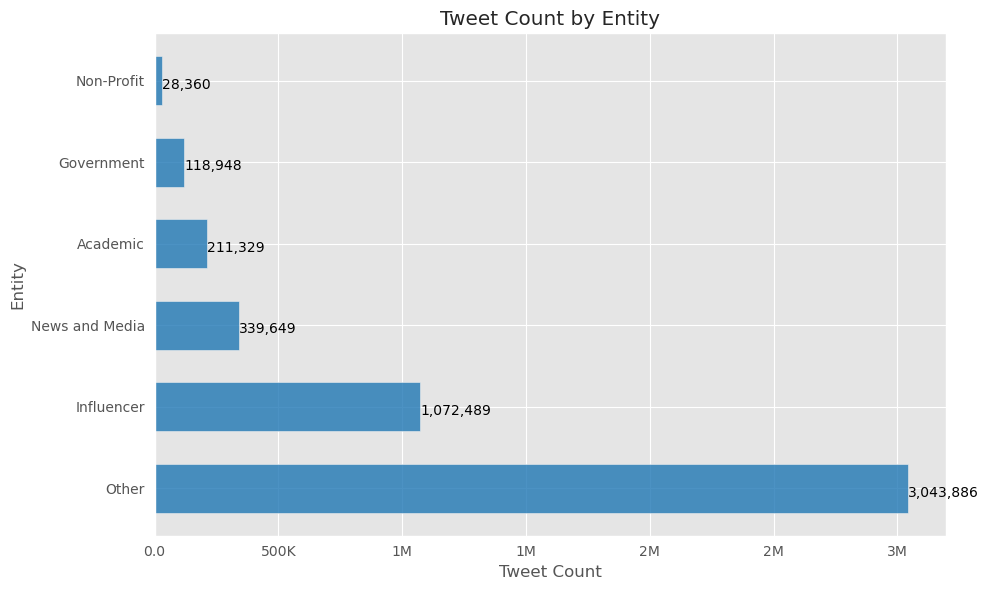

In [178]:
## Distribution of Tweets by Entites

import matplotlib.ticker as ticker

# set the plot style
plt.style.use('ggplot')
entity_summary_df = entity_summary_df.sort_values(by='tweets_count', ascending=False)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(entity_summary_df['entity'], entity_summary_df['tweets_count'], color='tab:blue', alpha=0.8, height=0.6)
ax.set_xlabel('Tweet Count')
ax.set_ylabel('Entity')
ax.set_title('Tweet Count by Entity')

# format the x-tick labels with a custom function
def format_tick(x, pos):
    if x >= 1_000_000:
        return f'{int(x/1_000_000)}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    else:
        return x

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

# add the values to the bars
for i, v in enumerate(entity_summary_df['tweets_count']):
    ax.text(v + 3, i - 0.1, str("{:,}".format(v)), color='black', fontsize=10)

# display the plot
plt.tight_layout()
plt.show()


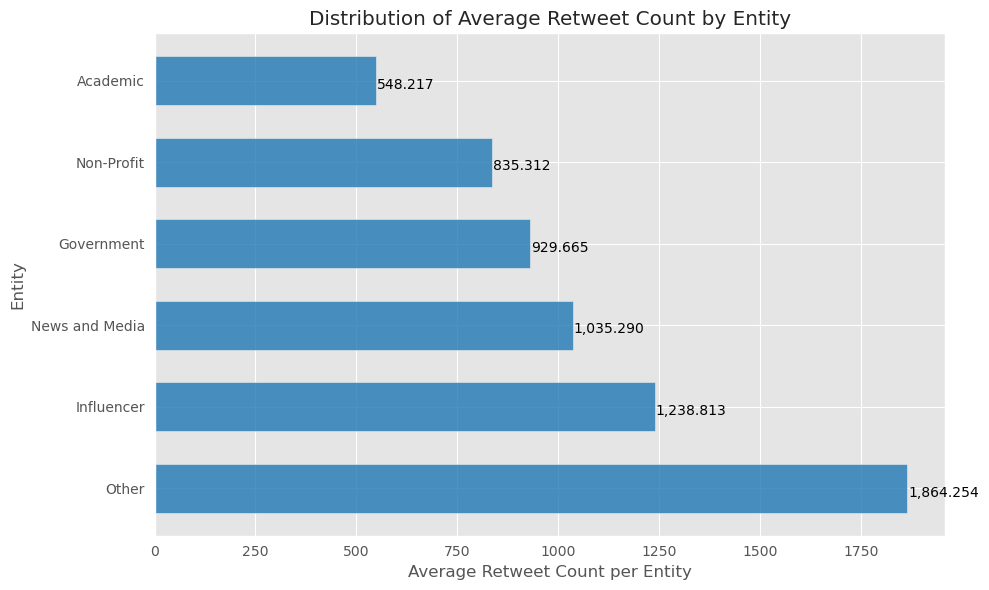

In [176]:
### Distribution of retweets
# set the plot style
plt.style.use('ggplot')
entity_summary_df = entity_summary_df.sort_values(by = 'avg_retweet_count', ascending = False) 
# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(entity_summary_df['entity'], entity_summary_df['avg_retweet_count'], color='tab:blue', alpha=0.8, height = 0.6)
ax.set_xlabel('Average Retweet Count per Entity')
ax.set_ylabel('Entity')
ax.set_title('Distribution of Average Retweet Count by Entity')

# add the values to the bars
for i, v in enumerate(entity_summary_df['avg_retweet_count']):
    ax.text(v + 3, i - 0.1, str("{:,.3f}".format(v)), color='black', fontsize=10)

# display the plot
plt.tight_layout()
plt.show()